In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
# iarunava_cell_images_for_detecting_malaria_path = kagglehub.dataset_download('iarunava/cell-images-for-detecting-malaria')
iarunava_cell_images_for_detecting_malaria_path = 'src/static/data/downloads/extracted/ZIP.data.lhnc.nlm.nih.gov_publ_Mala_cell_imagCpSVVrJBQVm1EAGSYJgFN2ZUxCZtjRh76bGSL61Dxmg.zip/cell_images'
print('Data source import complete.')

c:\Users\Utilisateur\Documents\GitHub Repos\Malaria-Detection-App\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [3]:
print(iarunava_cell_images_for_detecting_malaria_path)

src/static/data/downloads/extracted/ZIP.data.lhnc.nlm.nih.gov_publ_Mala_cell_imagCpSVVrJBQVm1EAGSYJgFN2ZUxCZtjRh76bGSL61Dxmg.zip/cell_images


# Malaria Detection

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.
* In 2017, there were an estimated 219 million cases of malaria in 90 countries.
* Malaria deaths reached 435 000 in 2017.
* The WHO African Region carries a disproportionately high share of the global malaria burden. In 2017, the region was home to 92% of malaria cases and 93% of malaria deaths.

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called "malaria vectors." There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.


***Diagnosis of malaria can be difficult***:

* Where malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.
* Malaria is an acute febrile illness. In a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.

***Microscopic Diagnosis***

Malaria parasites can be identified by examining under the microscope a drop of the patient’s blood, spread out as a “blood smear” on a microscope slide. Prior to examination, the specimen is stained  to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria. However, it depends on the quality of the reagents, of the microscope, and on the experience of the laboratorian.

![malaria](https://cdn1.sph.harvard.edu/wp-content/uploads/2015/03/Malaria-cells_CDC.jpg)

references :
* [1] https://www.who.int/news-room/fact-sheets/detail/malaria
* [2] https://www.cdc.gov/malaria/diagnosis_treatment/diagnosis.html


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import random
from torchvision.transforms import functional as F


import os
print(os.listdir('src/static/data/downloads/extracted/ZIP.data.lhnc.nlm.nih.gov_publ_Mala_cell_imagCpSVVrJBQVm1EAGSYJgFN2ZUxCZtjRh76bGSL61Dxmg.zip/cell_images'))

['Parasitized', 'Uninfected']


In [5]:
# Define your transforms for the training, validation, and testing sets

# Custom transform for adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(contrast=0.5),  # Random contrast
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),            # Add noise
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

## Dataset

In [6]:
img_dir='src/static/data/downloads/extracted/ZIP.data.lhnc.nlm.nih.gov_publ_Mala_cell_imagCpSVVrJBQVm1EAGSYJgFN2ZUxCZtjRh76bGSL61Dxmg.zip/cell_images'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [7]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20,
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


## Display one image

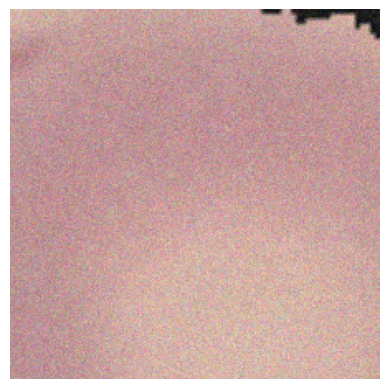

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and show an image
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor CHW to HWC
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to [0, 1] for display
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get one batch from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first image in the batch
imshow(images[0])

## Model ResNet50

In [9]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

model

c:\Users\Utilisateur\Documents\GitHub Repos\Malaria-Detection-App\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Utilisateur\Documents\GitHub Repos\Malaria-Detection-App\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

## Training The Network

In [11]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path, patience=5):
    """Train model with early stopping, tqdm, and accuracy tracking."""

    valid_loss_min = np.inf
    epochs_no_improve = 0
    best_model_wts = None

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_val = 0
        total_val = 0

        ###################
        # train the model #
        ###################
        model.train()
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs} [Training]", leave=False)

        for batch_idx, (data, target) in enumerate(train_loader_tqdm):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # Accuracy
            _, predicted = torch.max(output.data, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

            train_loader_tqdm.set_postfix(loss=train_loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch}/{n_epochs} [Validation]", leave=False)

            for batch_idx, (data, target) in enumerate(valid_loader_tqdm):
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                output = model(data)
                loss = criterion(output, target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

                # Accuracy
                _, predicted = torch.max(output.data, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

                valid_loader_tqdm.set_postfix(val_loss=valid_loss.item())

        # Accuracy calculations
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        # Print stats
        print(f"Epoch: {epoch} "
              f"\tTrain Loss: {train_loss:.6f} | Train Acc: {train_accuracy:.2f}% "
              f"\tVal Loss: {valid_loss:.6f} | Val Acc: {val_accuracy:.2f}%")

        ########################
        # early stopping check #
        ########################
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
            valid_loss_min = valid_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

In [ ]:
# train(5, model, optimizer, criterion, use_cuda, 'malaria_detection.pt')
trained_model = train(25, model, optimizer, criterion, use_cuda, save_path='best_model.pt', patience=3)

Epoch: 1 	Train Loss: 0.481823 | Train Acc: 76.78% 	Val Loss: 0.427188 | Val Acc: 81.67%
Validation loss decreased (inf --> 0.427188). Saving model...


Epoch 2/25 [Training]:  13%|█▎        | 40/302 [06:54<46:04, 10.55s/it, loss=0.414]

## Loading Saved Model

In [ ]:
model.load_state_dict(torch.load('malaria_detection.pt'))

## Testing The Model

In [ ]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

## Writing The Algorithm for Code Execution

In [ ]:
def load_input_image(img_path):
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

In [ ]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob("../input/cell_images/cell_images/Parasitized/*"))
uninf = np.array(glob("../input/cell_images/cell_images/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))
    plt.imshow(img)
    plt.show()